In [5]:
import numpy as np 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control_
import control
import math 
from sympy import symbols, solve

def pos(lst):
    return [x for x in lst if x > 0] or None
pi=math.pi
X= symbols('x')
PM=math.radians(75)
eq=((X-(1/X))/2)-(np.tan(PM))
x=float(pos(solve(eq,X))[0])
#Assigning some constants 
Fref=560e6
Fc=2.42100546e+06
R_ratio=2
P_divider=6
N=21
Fo=560e6
KVCO=90e6*2*pi
Icp=1e-3
Fp=x*Fc
Fz=Fc/x
k=(KVCO*Icp)/(2*pi*N)
R1=(2*(pi)*Fc)/(k*(1-(1/(x**2))))
wz=2*pi*Fz                       
C1=1/(R1*wz)
C2=C1/((x**2)-1)
Ceq=C1*C2/(C1+C2)

In [6]:
R1

3611.983658564913

In [7]:
Icp*R1*(1e-12)*(96e6)

0.00034675043122223164

In [8]:
Icp*(1e-12)/C1

7.233533824497776e-06

In [9]:
x*2

15.191508225450312

In [10]:
print(R1,k,Icp,KVCO,C1)

3611.983658564913 4285.714285714286 0.001 565486677.6461627 1.3824501609618589e-10


In [11]:
#VCO phase noise 
T_osc=control.tf([1,2*pi*10e4],[1,0])
T_osc=T_osc*30
s=control.tf([1],[1,0,0])
T_osc=T_osc*s
T_osc

TransferFunction(array([3.00000000e+01, 1.88495559e+07]), array([1, 0, 0, 0]))

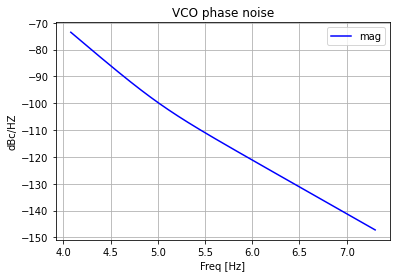

In [12]:
#VCO phase noise 
w=np.linspace(2*pi*12e3,2*pi*20e6,500000)
(mag, phase_rad, w) = control.bode(T_osc, w,dB=True,Hz=True,plot=False)
'''for i in range(np.shape(w)[0]):
    if 10*np.log10(mag[i]) <= -125 :
        mag[i:]=mag[i]
        break'''
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('VCO phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [13]:
#Reference phase noise 
T_ref=control.tf([1,1e3*2*pi],[1,0])
T_ref_1=control.tf([1,1e4*pi],[1])
T_ref_2=control.tf([1,1e7*2*pi],[1])
T_ref_3=control.tf([1],[1,1e8*2*pi])
T_ref=T_ref*(2.224970786e-10)*T_ref_1*T_ref_2*T_ref_3
s=control.tf([1],[1,0,0])
T_ref=T_ref*s
T_ref

TransferFunction(array([2.22497079e-10, 1.39882917e-02, 5.27073874e+02, 2.75952239e+06]), array([1.00000000e+00, 6.28318531e+08, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00]))

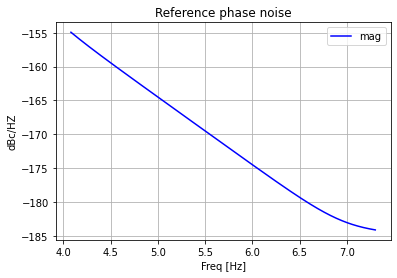

In [14]:
#Reference phase noise 
(mag_ref, phase_rad_ref, w) = control.bode(T_ref, w,dB=True,Hz=True,plot=False)
'''for i in range(np.shape(w)[0]):
    if 10*np.log10(mag_ref[i]) <= -150 :
        mag_ref[i:]=mag_ref[i]
        break'''
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_ref), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('Reference phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [46]:
# transfer noise of loop filter is RC circuit noise 
T_loopfilter=4*4.11e-21*R1

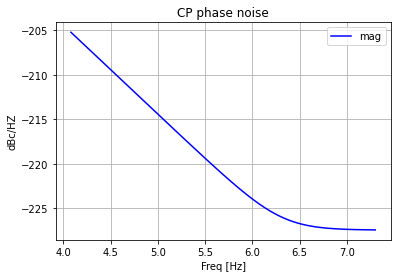

In [71]:
#CP 
# TDC noise specturm 
delta=1e-12
Tref=1/96e6
T_TDC=(4*(pi**2)*(delta**2))/(12*Tref)
T_CP_noise=control.tf([1,2*2e6*pi],[1,0])
T_CP_noise=T_CP_noise*(5.40613e-24*(Icp))/(300e-6)
(mag_CP_noise, phase_rad_CP_noise, w) = control.bode(T_CP_noise, w,dB=True,Hz=True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_CP_noise), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('CP phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [72]:
T_CP_noise

TransferFunction(array([5.40613000e-27, 6.79354332e-20]), array([0.0003, 0.    ]))

TransferFunction(array([2.14002317e-03, 4.28571429e+03]), array([1.21757663e-18, 1.40683394e-10, 0.00000000e+00, 0.00000000e+00]))

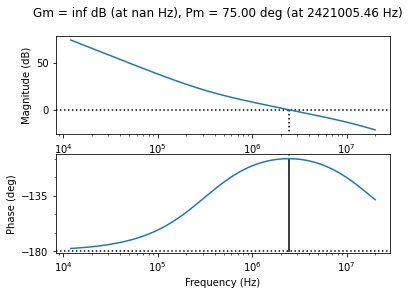

In [73]:
# open gain for Feedback loop 
Ts=control.tf([R1*C1*k,k],[R1*Ceq,1,0,0])
Ts=Ts/((C1+C2))
(mag_Feed, phase_rad_Feed, w) = control.bode_plot(Ts, w,dB=True, deg= True ,Hz=True, margins=True)
Ts

In [74]:
# # Feedback of the loop in the middle 
# #Closed loop 
# Bs_=(Ts)/(1+(Ts))
# (mag_FB, phase_rad_FB, w) = control.bode_plot(Bs, w,dB=True, deg= True )

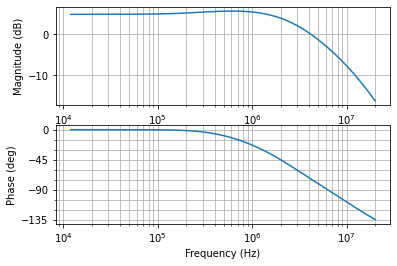

In [75]:
# the overall closed loop
Bs=(Ts*N)/(1+(Ts))
Bs=Bs/(R_ratio*P_divider)
(mag_FB, phase_rad_FB, w) = control.bode_plot(Bs, w,dB=True, Hz=True,deg= True )


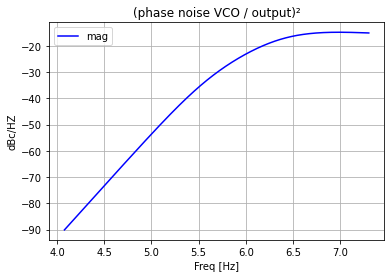

In [76]:
#Transfer function of different blocks 
#Transfer function of VCO phase output to phase of VCO
T_out_VCO=1/((1+(Ts))*P_divider)
(mag_out_VCO, phase_out_VCO, w) = control.bode_plot(T_out_VCO, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_VCO)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(phase noise VCO / output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

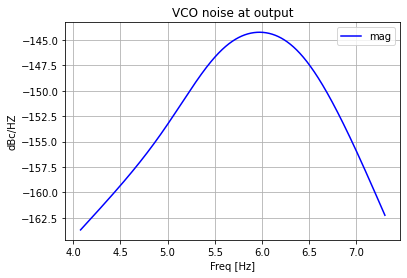

In [77]:
VCO_noise_output=mag*((mag_out_VCO)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('VCO noise at output')
plt.grid() 
plt.legend(labels=('mag',))

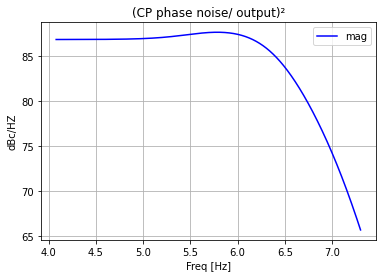

In [78]:
#Transfer function of different blocks 
#Transfer function of CP phase output to phase of CP
T_out_CP=Ts*((2*pi)/Icp)*N
T_out_CP=T_out_CP/(1+Ts)
T_out_CP=T_out_CP/P_divider
(mag_out_CP, phase_out_CP, w) = control.bode_plot(T_out_CP, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_CP)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(CP phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

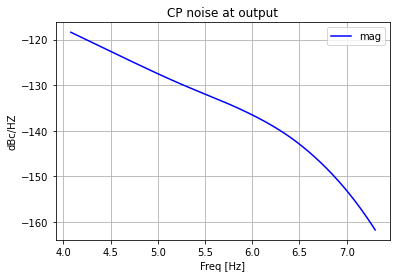

In [79]:
CP_noise_output=mag_CP_noise*((mag_out_CP)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(CP_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('CP noise at output')
plt.grid() 
plt.legend(labels=('mag',))

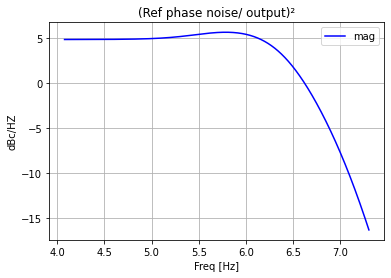

In [80]:
#Transfer function of different blocks 
#Transfer function of CP phase output to phase of Reference
T_out_ref=Bs
(mag_out_ref, phase_out_ref, w) = control.bode_plot(T_out_ref, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_ref)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(Ref phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

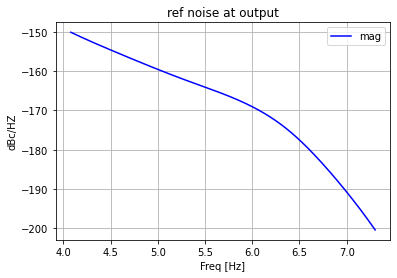

In [81]:
ref_noise_output=mag_ref*((mag_out_ref)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(ref_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('ref noise at output')
plt.grid() 
plt.legend(labels=('mag',))

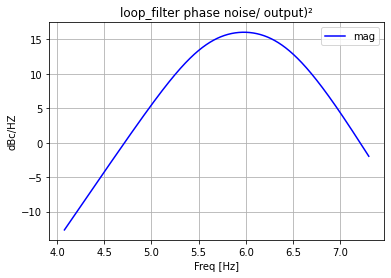

In [82]:
#Transfer function of different blocks 
#Transfer function of LOOP_FILTER phase output to phase of Reference

s_=control.tf([1,0],[1])
T_out_loop_filter=((KVCO/s_)*(1/P_divider))/(1+Ts)
(mag_out_loop_filter, phase_out_loop_filter, w) = control.bode_plot(T_out_loop_filter, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_loop_filter)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('loop_filter phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

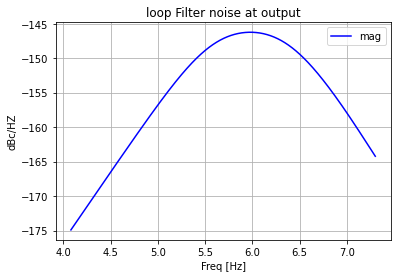

In [83]:
loop_filter_noise_output=(4.112e-21)*4*R1*((mag_out_loop_filter)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(loop_filter_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('loop Filter noise at output')
plt.grid() 
plt.legend(labels=('mag',))

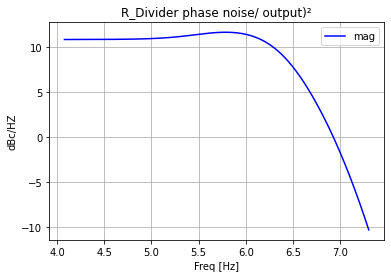

In [84]:
#Transfer function of R_Divider phase output to phase of Reference

T_out_R_Divider=Bs*R_ratio
(mag_out_R_Divider, phase_out_R_Divider, w) = control.bode_plot(T_out_R_Divider, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_R_Divider)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('R_Divider phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

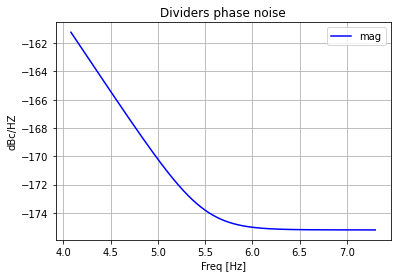

In [85]:
# Divider transfer phase noise 
T_Divider=control.tf([1,2*300e3*pi],[1,0])
T_Divider=T_Divider*3.01506e-18

(mag_Divider, phase_rad_Divider, w) = control.bode(T_Divider, w,dB=True,Hz=True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('Dividers phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [86]:
T_Divider 

TransferFunction(array([3.01506000e-18, 5.68325421e-12]), array([1, 0]))

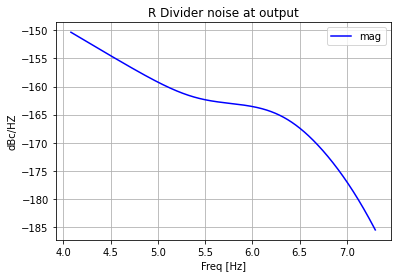

In [87]:
R_divider_noise_output=((mag_out_R_Divider)**2)*mag_Divider
plt.plot(np.log10(w/(2*pi)), 10*np.log10(R_divider_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('R Divider noise at output')
plt.grid() 
plt.legend(labels=('mag',))

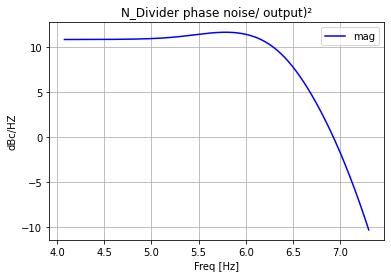

In [88]:
#Transfer function of N_Divider phase output to phase of Reference

T_out_N_Divider=Bs*R_ratio
(mag_out_N_Divider, phase_out_N_Divider, w) = control.bode_plot(T_out_N_Divider, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_N_Divider)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N_Divider phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

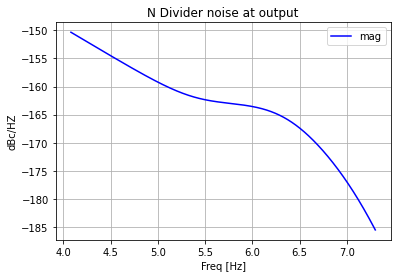

In [89]:
N_divider_noise_output=((mag_out_N_Divider)**2)*mag_Divider
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N Divider noise at output')
plt.grid() 
plt.legend(labels=('mag',))

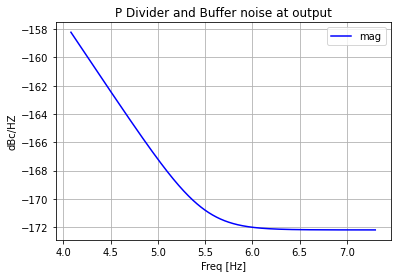

In [90]:

plt.plot(np.log10(w/(2*pi)), 10*np.log10(2*mag_Divider), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('P Divider and Buffer noise at output')
plt.grid() 
plt.legend(labels=('mag',))

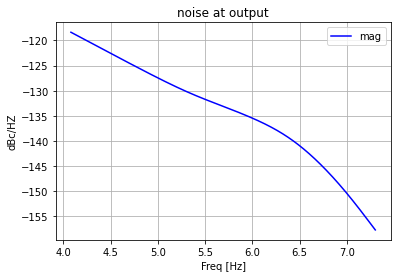

In [91]:
#calculation every noise at the output 
noise_output=VCO_noise_output+CP_noise_output+ref_noise_output+loop_filter_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('mag',))

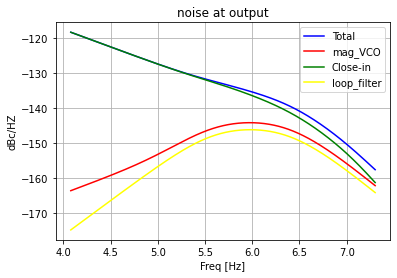

In [92]:
#comparison
noise_output=VCO_noise_output+CP_noise_output+ref_noise_output+loop_filter_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
noise_output_comp=CP_noise_output+ref_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output), 'blue') 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output), 'red')
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_comp), 'green') 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(loop_filter_noise_output), 'yellow') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('Total','mag_VCO','Close-in','loop_filter',))

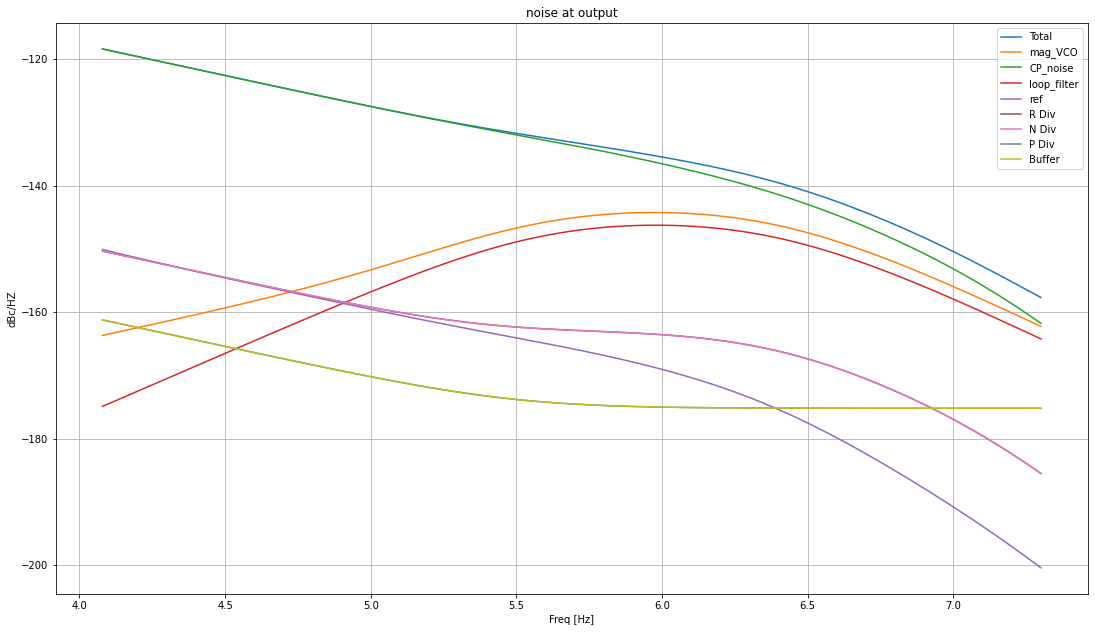

In [93]:
#comparison
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
noise_output=VCO_noise_output+CP_noise_output+ref_noise_output+loop_filter_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
noise_output_comp=CP_noise_output+ref_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output))
# plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_comp)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(CP_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(loop_filter_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(ref_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(R_divider_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider)) 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('Total','mag_VCO','CP_noise','loop_filter','ref','R Div','N Div','P Div','Buffer'))

In [94]:
jitter= np.trapz(noise_output, x=w/(2*pi))
jitter=jitter*2
jitter=(math.sqrt(jitter))/(2*pi*560e6)
jitter*1e15

153.058388392713

In [95]:
# to calculate contribution of eact block 
def jitter(y):
    w=np.linspace(2*pi*12e3,2*pi*20e6,500000)
    jitter= np.trapz(y, x=w/(2*pi))
    jitter=jitter*2
#     jitter=(math.sqrt(jitter))/(2*pi*560e6)
    return(jitter*1e15)

In [96]:
(jitter(VCO_noise_output)/jitter(noise_output))*100

10.164521283970705

In [97]:
(jitter(CP_noise_output)/jitter(noise_output))*100

83.03591896403645

In [98]:
(jitter(ref_noise_output)/jitter(noise_output))*100

0.04555548533034205

In [99]:
(jitter(loop_filter_noise_output)/jitter(noise_output))*100

6.401828699427788

In [100]:
(jitter(R_divider_noise_output)/jitter(noise_output))*100

0.1326943429797446

In [101]:
(jitter(N_divider_noise_output)/jitter(noise_output))*100

0.1326943429797446

In [102]:
(jitter(2*mag_Divider)/jitter(noise_output))*100

0.08678688127518216